# **Image Filtering**


**Recommended Reading/Viewing:**

1. [How Blurs & Filters Work - Computerphile](https://youtu.be/C_zFhWdM4ic)

**Additional Reading**
1. Forsyth, David A., and Jean Ponce. Computer vision: a modern approach. Prentice Hall Professional Technical Reference, 2002. Section 4.1

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:
````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

### AP: location argument

In [1]:
#(Optional) Download data + videos if you don't have them.
import os, sys
sys.path.append('..')
from util.get_and_unpack import get_and_unpack

if not os.path.isdir('../data/'):
    url = 'http://www.welchlabs.io/unccv/the_original_problem/data/data.zip'
    get_and_unpack(url, location='..')
    
if not os.path.isdir('../videos/'):
    url = 'http://www.welchlabs.io/unccv/the_original_problem/videos.zip'
    get_and_unpack(url, location='..')   

![](../graphics/spacer_small.png)

### **Problems with our implementation of Robert's Cross**

1. **Noisy** - Robert's Cross is quite susceptible to noise.
2. **Anisotropic** - doesn't respond as strongly to slanted edges. 
3. **Slow** as we've implemented it here.
4. **No Direction** as we've implemented Robert's Cross here, we only learn about the **magnitude** of our esimate of the image intensity derivative, not its **direction.** 

Hopefully you've taken some time to think through some possible fixes to these problems. Let's start by seeing if we can make our images less noisy.

## **Noise**

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Load image
im = imread('../data/medium_2/ball/ball_3.jpg')

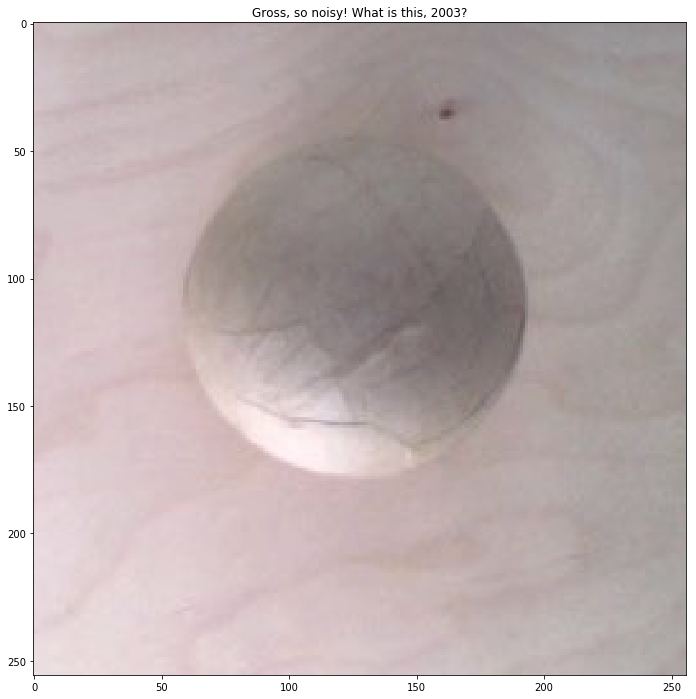

In [4]:
#Let's have a look
fig = figure(0, (12,12))
imshow(im)
title('Gross, so noisy! What is this, 2003?');

- This is a particularly noisy image from our dataset - it was captured under relatively low light conditions with the webcam of my 2008 macbook.
- The z-axis height of the surface below corresponds to the grayscale intensity of our image.

![](../videos/noisy_image_rotating_3.gif)

- Let's have a look at the result of our implementation of Robert's Cross from earlier time on this image. 

In [5]:
#Add path to top level directory so we can access utilities
import sys
sys.path.append('..')

#Import grayscale method
from util.image import convert_to_grayscale

### AP: im/255.  as it expects a scaled image as per the docstring

In [6]:
gray = convert_to_grayscale(im/255.)

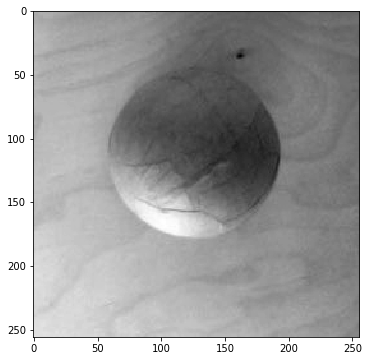

In [7]:
fig = figure(0, (6,6))
imshow(gray, cmap = 'gray');

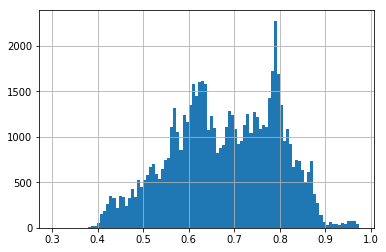

In [8]:
hist(gray.ravel(), 100);
grid(1)

In [9]:
from util.filters import roberts_cross

In [10]:
edges = roberts_cross(gray)

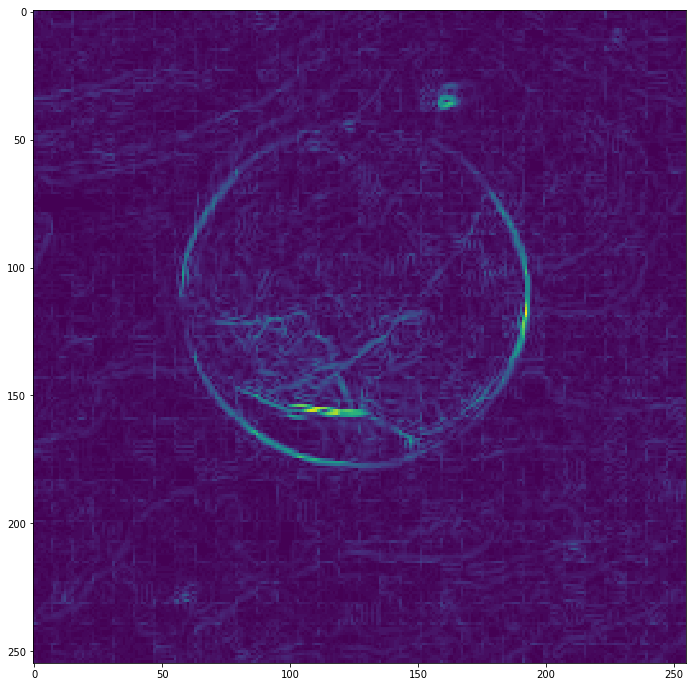

In [11]:
fig = figure(0, (12,12))
imshow(edges);

## Now, how can we remove some of the noise from our image?

- Any ideas?
- Are there properties of our noise that we can exploit to help us seperate it from our signal?

![](../videos/noisy_image_rotating_1.gif)

## **Local Averages**

A very successful/popular appraoch to noise reduction is to replace the individual pixels in our images with some type of weighted average of their local neighborhoods.

![](../graphics/averaging_slides/01.png)

# **How would this operation change the appearance of our image?**

![](graphics/spacer_small.png)

- Let's find out!
- Now, before we code this up, let's generalize this process a little.
- A more general way to think about the average of our neighborhood is as the dot product of our image patch with a (3x3) matrix.

In [12]:
#Little trick to progress through slides within the notebook
from IPython.display import Image, display
from ipywidgets import interact

#Quick method to let me step through "slides"
def slide_show(slide_num=1):     
    display(Image('../graphics/averaging_slides/' + str(slide_num).zfill(2) + '.png'))

In [13]:
interact(slide_show, slide_num = (1, 2));

interactive(children=(IntSlider(value=1, description='slide_num', max=2, min=1), Output()), _dom_classes=('wid…

- It turns out that taking the dot product of our image patch with a small matrix or kernel like this is incredibly common in computer vision.
- Doing this across a whole image is called filtering, convolution, or cross correlation, we'll get into the details later.
- Let's write a method to filter an image with an arbitray kernel/filter
- First, let's think though how exactly our method will work.

![](../graphics/question_three-01.png)

- Now, let's think about how to describe what we would like to do mathematically.
- But first, we need to define the coordinate system we'll use on our images.

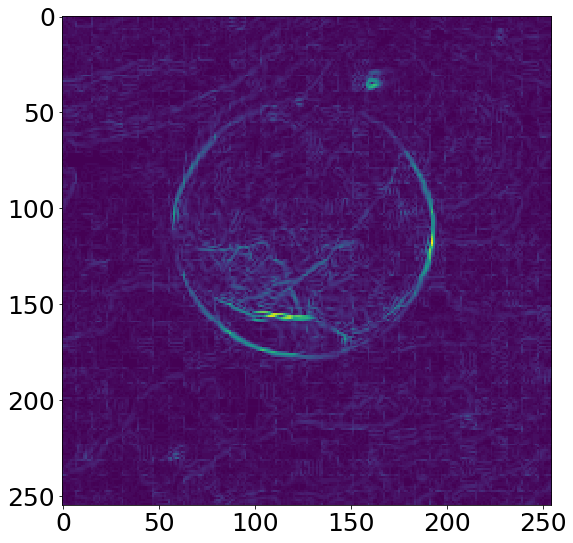

In [14]:
fig = figure(0, (9,9))
ax = fig.add_subplot(111)
ax.imshow(edges)
ax.tick_params(axis='both', which='major', labelsize=25)

- As you may already know, the coordinate system of images in matplotlib is defined with the origin in the upper left hand corner, positive is down and to the right. Our first index corresponds to the vertical dimension and our second index corresponds to the horizontal.

![](../graphics/question_four-01.png)

- For convenience (for now), let's define the the origin of Kernel coordinate systems to be in the center of our Kernel, and let our kernel be of size 2N+1 by 2M+1. This forces our kernel have odd dimensions (as opposed to even), but we can deal with that for now.

![](graphics/spacer_small.png)

![](graphics/spacer_small.png)

# An Equation!

# $$
I \star K = S(i, j) = \sum_{m=-M}^M \sum_{n=-N}^N I(i+m, j+n)K(m, n)
$$

- Alright, now we're getting somewhere!
- This operation is know as [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation) in 2 dimensions, and is very similar to [convolution](https://en.wikipedia.org/wiki/Convolution), something we'll discuss later. To compute convolution instead of cross correlation, we simply flip our kernel relavive to our images: $S(i, j) = \sum_{m=-M}^M \sum_{n=-N}^N I(i-m, j-n)K(m, n)$.
- **We'll use they symbol $ \star $ to denote cross correlation**
- Not be be confused with $\ast$, which often denotes convolution.
- Now, we're almost ready to code this up, but first we have one last adjustment to make. 
- Since both our kernel and images are going to be represented as numpy arrays, we need to index them each from the upper right corner:



![](graphics/question_five-01.png)

![](../graphics/spacer_small.png)

___

### AP: Changed K(m-M,n-N) to  K(m+M,n+N). 

###  AP:  for i=0, j = 0, M=3, N=5 we want to access numpy array K. for m = -3 and n = -5 => K(-3 + 3, -5 + 5)

$$
S(i, j) = \sum_{m=-M}^M \sum_{n=-N}^N I(i+m, j+n)K(m+M, n+N)
$$

- Ok, we finally have an equation!
- Ok, we're *finally* ready to do some filtering!
- We could implement our filter in exactly as written in the above equation, howewever this would require iterating throug $i, j$ as well, making for 4 for-loops. Also, the indexing of S is a little weird - we'll simplify things a little, and us np.multiply to multiply our image patch and kernel matrices together:

In [15]:
def filter_2d(im, kernel):
    '''
    Filter an image by taking the dot product of each 
    image neighborhood with the kernel matrix.
    Args:
    im = (H x W) grayscale floating point image
    kernel = (M x N) matrix, smaller than im
    Returns: 
    (H-M+1 x W-N+1) filtered image.
    '''

    M = kernel.shape[0] 
    N = kernel.shape[1]
    H = im.shape[0]
    W = im.shape[1]
    
    filtered_image = np.zeros((H-M+1, W-N+1), dtype = 'float64')
    
    for i in range(filtered_image.shape[0]):
        for j in range(filtered_image.shape[1]):
            image_patch = im[i:i+M, j:j+N]
            filtered_image[i, j] = np.sum(np.multiply(image_patch, kernel))
            
    return filtered_image

![](graphics/averaging_slides/02.png)

- Now, remember that the whole point of all of this was to try to reduce the noise in our images by taking local averges. 
- Another name for this local average kernel is a box or [boxcar function](https://en.wikipedia.org/wiki/Boxcar_function).
- Let's try doing this with our new `filter_2d` method. 

In [16]:
kernel = (1/9)*np.ones((3,3))

In [17]:
kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

In [18]:
# Filter Image!
im_filtered = filter_2d(gray, kernel)

In [19]:
im_filtered.shape

(254, 254)

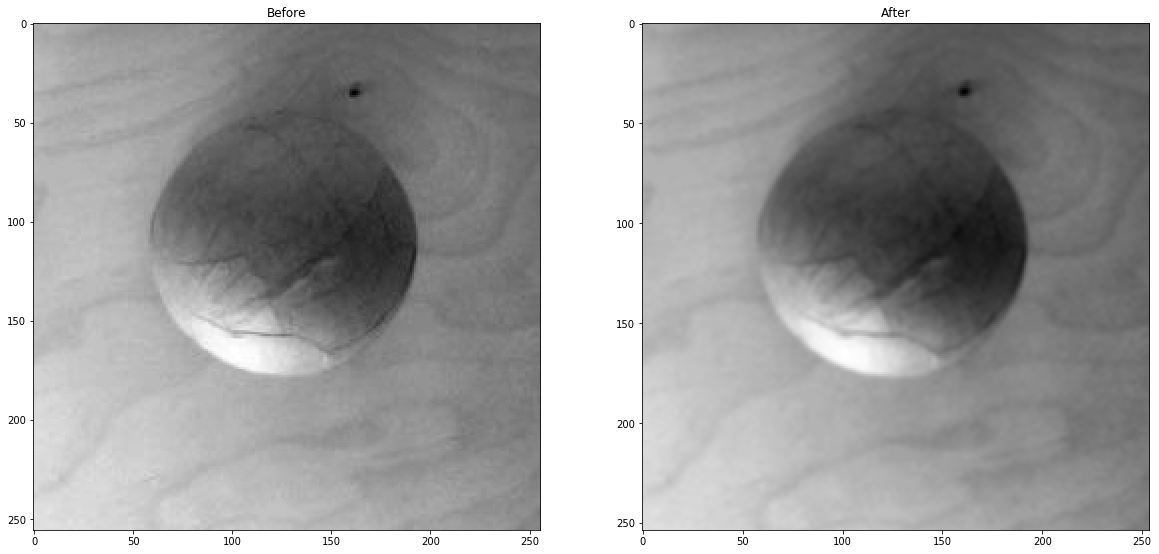

In [20]:
fig = figure(0, (20,10))

fig.add_subplot(1,2,1)
imshow(gray, cmap = 'gray');
title('Before');

fig.add_subplot(1,2,2)
imshow(im_filtered, cmap = 'gray');
title('After');

- It may be a little hard to see, but our filtered image is a little smoother!

# How could we smooth our image even further?

![](../graphics/spacer_small.png)

- One way to achieve this is to use a larger kernel:

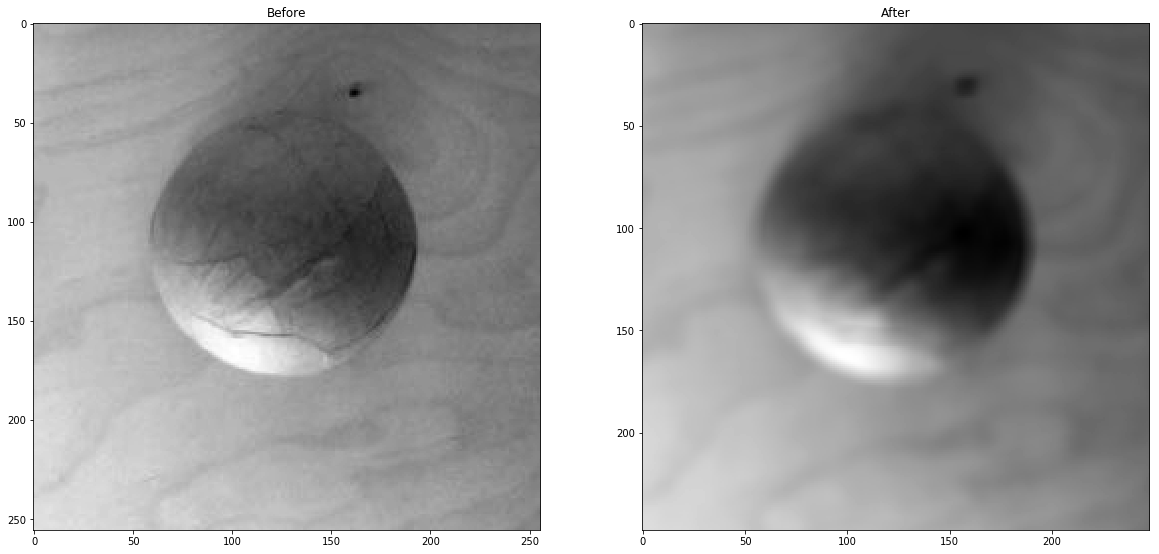

In [21]:
kernel = (1/81)*np.ones((9,9))
im_filtered = filter_2d(gray, kernel)

fig = figure(0, (20,10))

fig.add_subplot(1,2,1)
imshow(gray, cmap = 'gray');
title('Before');

fig.add_subplot(1,2,2)
imshow(im_filtered, cmap = 'gray');
title('After');

- Now we can really see some smoothing taking place!
- Let's have a look at our filtering operation on another image:

In [22]:
kernel = (1/25)*np.ones((9,9))

In [23]:
#Load up another image:
brick = imread('../data/easy/brick/brick_4.jpg')

### AP: Scaled brick

In [24]:
#Convert to grayscale and filter
brick_gray = convert_to_grayscale(brick/255.)
brick_filtered = filter_2d(brick_gray, kernel)

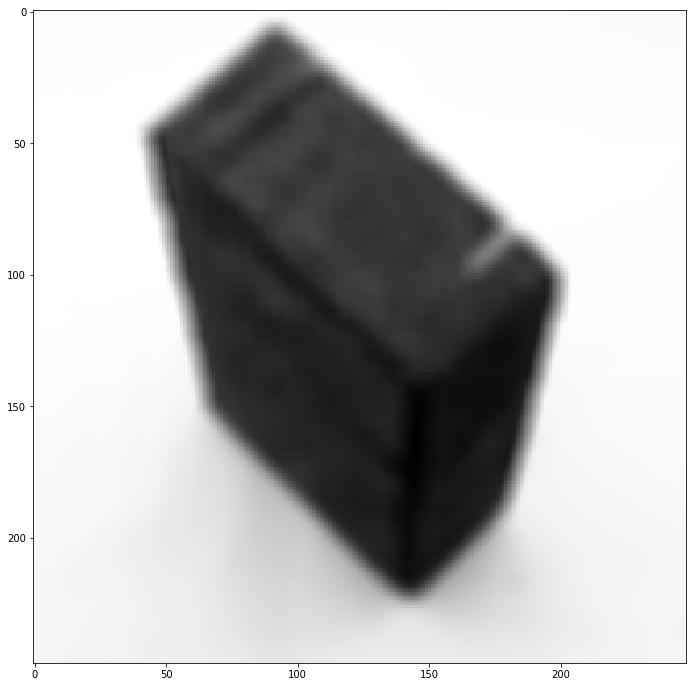

In [25]:
fig = figure(0, (12,12));
imshow(brick_filtered, cmap = 'gray');

- A blurry brick! 
- Now, do the edges of this brick look weird to you at all? 
- Anything strange going on?
- To me, it almost looks like there's some kind of "crosshash pattern" around our edges.
- Let's look at a **toy** example:

In [26]:
toy_image = np.zeros((21,21))
toy_image[10, 10] = 1.0

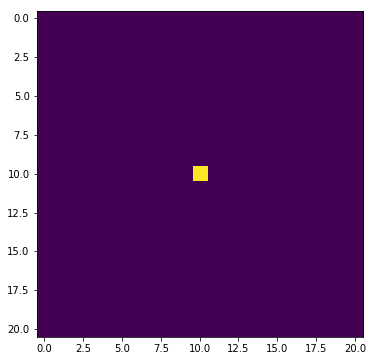

In [27]:
fig = figure(0, (6, 6))
imshow(toy_image,vmin=0, vmax=1);

- Our toy image is a small `(21x21)`, image of all zeros with a single value of 1 in the very center.
- A discrete 2d [Dirac Delta](https://en.wikipedia.org/wiki/Dirac_delta_function) function.
- Now, what will happen if we filter this function with our moving average?

### AP(Suggestion): Shouldn't all the options in this question have same scale for colorbar? While trying to answer this question my self, I attributed yellow = 1 and then concluded that after filtering since the internsity will become 0.04 , I looked for a color on input image's colorbar, so none of these options made sense to me until much later i noticed the scales on colorbars.

![](../graphics/question_six-01.png)

![](graphics/spacer_small.png)

- As you may have correctly guessed, the correct answer is **a**. 

*Quick Explanation*
- One way to think about this is imagining our kernel sliding over our image
- When our kernel is in, let's say, the upper left corner, all image values are zero - resulting in a filtered value of zero. 
- Now, whevever our kernel *eventually* reaches our central pixel, whenever our kernel overlaps this pixel at all, the resulting output value will be $\frac{1}{25} \cdot 1 = 0.04$.
- It doesn't matter if our kernel is directly above our central pixel or if the central pixels just "clips" the lower corner of our kernel - if the central pixel is anywhere in the kernel, our output value will be a constant $0.04$
- This is why the central patch of our correct answer **a** is **uniform**.
- Finally, the answer is not **b**. **b** *is* uniform, but it's the central patch is not quite large enough - it's about `3x3` - it should be the same size as our filter.

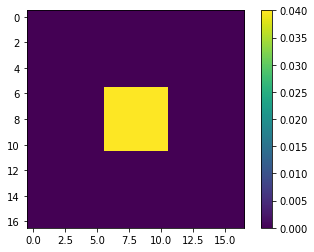

In [28]:
#And finally, just in case you're suspicious, we can actually perform the filtering in question:
box_5 = (1/25)*np.ones((5,5))
filtered_box_5 = filter_2d(toy_image, box_5)
imshow(filtered_box_5)
colorbar()

### AP: Above result kind of gives an impression that, filtering has made the center pixel spread without changing its intensity (even though there is a colorbar). How do you feel about the below result, where we keep the colorbar same.

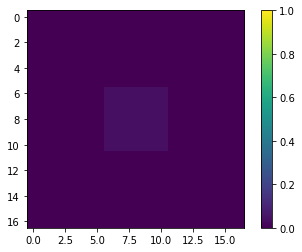

In [29]:
imshow(filtered_box_5, vmin=0, vmax=1)
colorbar()

### AP: So the center pixel's intensity was distributed(smoothed) as a result of filtering. 

- Boom!
- Now, the reason for this fun little exercise:

## **This may not be a very "natural" way to blur our images.**

[Placeholder] Video of bluring image of brick with camera and/or bluring a printed out delta function.

## **How then, should we blur our images?**

- For our blur to look more natural, or behave as a de-focused camera lens, it would make sense for your blur to smoothly fade out from the cental bright pixel - more like option **d** in the question above.
- We can accomplish this by taking a **weighted average** around the central pixel in our kernel instead of a uniform average as we have thus far.
- A very popular way to do this in image processing is to use **guassian kernels**:

![](videos/rotating_guassians.gif)

- **Guassian kernels** have lots of nice properties, but the main one we care about there is that they decrease monotonically and smoothly from their central point.
- Checkout section 5.7 of Computer Vision by Shapiro + Stockman for some more nice properties.
- For now, let's figure out how to implement these guys in python.
- Here's the equation for a [2 dimensional symmetric guassian kernel](https://en.wikipedia.org/wiki/Gaussian_blur):

## $$
G_{\sigma}(x, y) = \frac{1}{2 \pi \sigma^2} exp \bigg(- \frac{(x^2+y^2)}{2 \sigma^2} \bigg)
$$

- Let's think through this function a bit.
- What do $x$, $y$, and $\sigma$ represent?
- What values of $x$ and $y$ maximize sigma?
- And most importantly, **how do we make this continuous function definition into a kernel we can actually use?**

![](graphics/spacer_small.png)

![](../graphics/question_seven-01.png)

![](graphics/spacer_small.png)

*Explanation*
- One way I like to think through problems like this is it to pick some test numbers to help me think through the problem. 
- Let's pick the size of our kernel to be `(5x5)`, this would make `k=2`. 
- We know that our gaussian kernel should reach a maximum value at the center of our kernel `(i=2, j=2)`.
- Our Gaussian Kernel Function $G_{\sigma}(x, y)$ reaches a maximum when `x=0` and `y=0`.
    - One way to think about this is that any non-zero value of $x$ or $y$, when squared will become a positive number, and will make the overall argument of our exponent negative. $e$ to a negative power will always be smaller than $e^{0}$, so $G_{\sigma}(x, y)$ reaches a maximum when `x=0` and `y=0`.
- So the correct answer above should give an argmument of zero inside our exponent at the center of our kernel, when `(i=2, j=2)`.  
- The only answer that meets the criteria is **d**.

Alright, let's code it up!

### AP: Handle sigma == 0 

In [30]:
def make_gaussian_kernel(size, sigma):
    '''
    Create a gaussian kernel of size x size. 
    Args: 
    size = must be an odd positive number
    sigma = standard deviation of gaussian in pixels
    Returns: A floating point (size x size) guassian kernel 
    ''' 
    #Make kernel of zeros:
    kernel = np.zeros((size, size))
    
    if sigma == 0:
        return kernel 
    
    #Helpful for indexing:
    k = int((size-1)/2)
    
    for i in range(size):
        for j in range(size):
            kernel[i, j] = (1/(2*np.pi*sigma**2))*exp(-((i-k)**2 + (j-k)**2)/(2*sigma**2))
            
    return kernel

In [31]:
gaussian_kernel = make_gaussian_kernel(size = 11, sigma = 2)

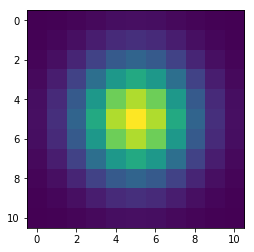

In [32]:
imshow(gaussian_kernel)

And in 3d:

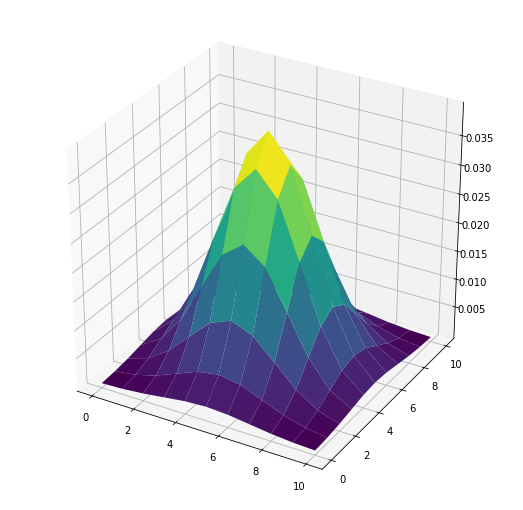

In [33]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(range(11), range(11))
# Plot kernel as 3d surface.
fig = plt.figure(0, (9,9))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, gaussian_kernel, cmap=cm.viridis, antialiased=True)

## **Alright, let's put it all together.**

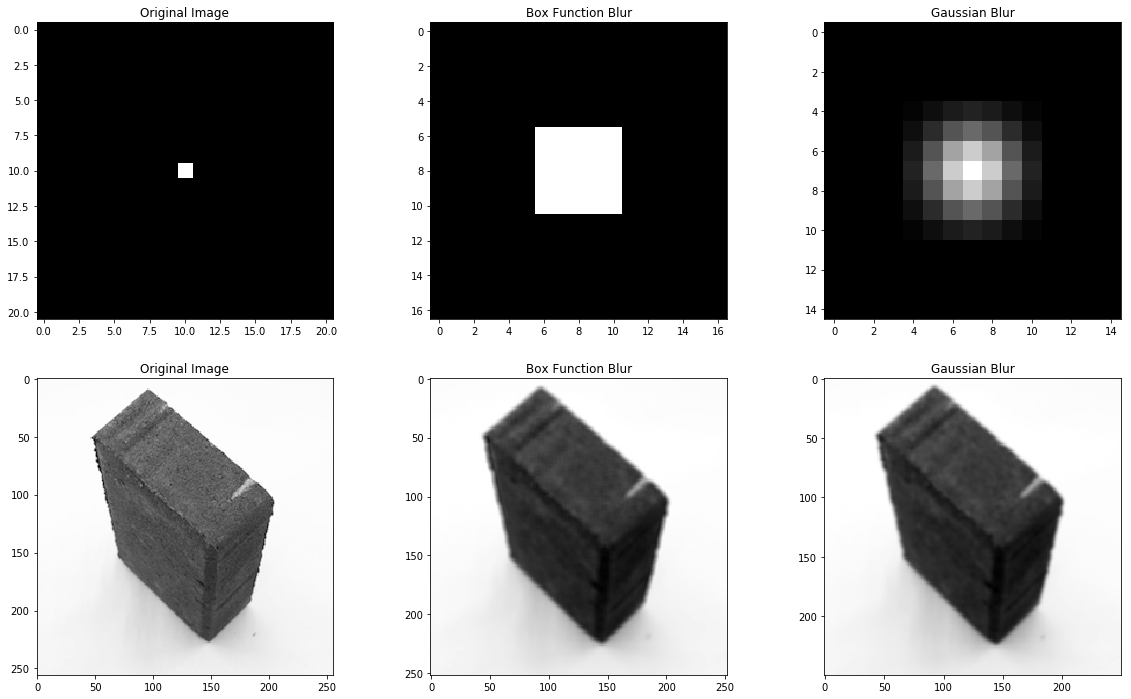

In [34]:
box_kernel = (1/25)*np.ones((5,5))
gaussian_kernel = make_gaussian_kernel(size = 7, sigma = 1.5)

fig = figure(0, (20, 12))

fig.add_subplot(2,3,1)
imshow(toy_image, cmap = 'gray')
title('Original Image');

fig.add_subplot(2,3,2)
imshow(filter_2d(toy_image, box_kernel), cmap = 'gray')
title('Box Function Blur');

fig.add_subplot(2,3,3)
imshow(filter_2d(toy_image, gaussian_kernel), cmap = 'gray')
title('Gaussian Blur');

fig.add_subplot(2,3,4)
imshow(brick_gray, cmap = 'gray')
title('Original Image');

fig.add_subplot(2,3,5)
imshow(filter_2d(brick_gray, box_kernel), cmap = 'gray')
title('Box Function Blur');

fig.add_subplot(2,3,6)
imshow(filter_2d(brick_gray, gaussian_kernel), cmap = 'gray')
title('Gaussian Blur');

Ok, so we've gound a good method for reducing the noise level in our images - let's try it out with our edge image from Robert's cross, and see if we can reduce some of the noise.

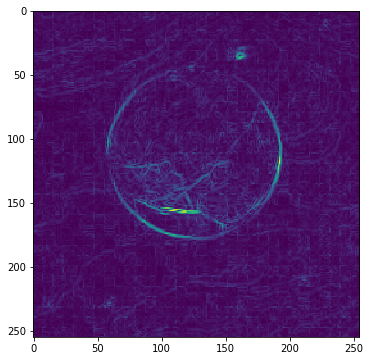

In [35]:
fig = figure(0, (6,6))
imshow(edges);

In [36]:
#Make gaussian kernel
gaussian_kernel = make_gaussian_kernel(size = 11, sigma = 2)

#Filter edge image
edges_filtered = filter_2d(edges, gaussian_kernel)

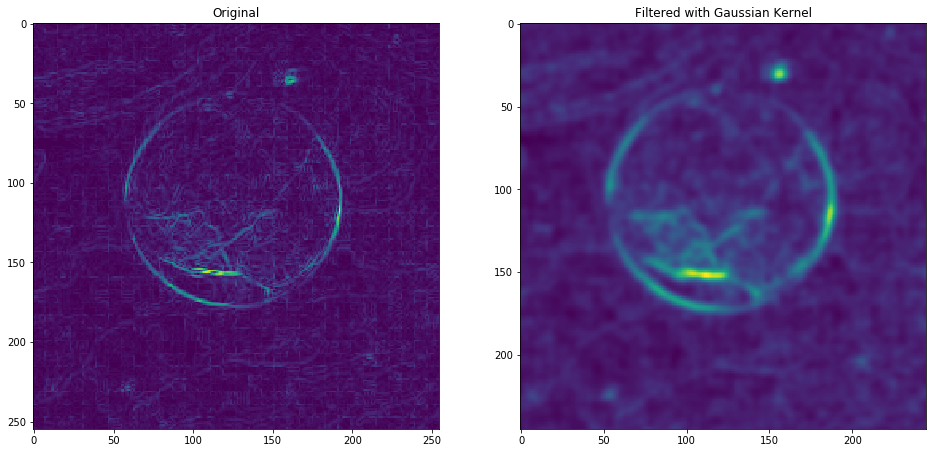

In [37]:
fig = figure(0, (16,9))
fig.add_subplot(1,2,1)
imshow(edges)
title('Original');

fig.add_subplot(1,2,2)
imshow(edges_filtered)
title('Filtered with Gaussian Kernel');

- As you can see, some of our noise has been smoothed out be our gaussian kernel. 
- This is a little easier to see in 3d:

![](../videos/roberts_world_10.gif)

- Finally, we can use one of my favorite tools, the interact module to play with our smoothing:

In [38]:
from ipywidgets import interact

In [39]:
def blur_and_display(size = 5, sigma = 2):
    #Make gaussian kernel
    gaussian_kernel = make_gaussian_kernel(size = size, sigma = sigma)

    #Filter edge image
    edges_filtered = filter_2d(edges, gaussian_kernel)
    
    fig = figure(0, (9,9))
    imshow(edges_filtered)

In [40]:
interact(blur_and_display, size = (3, 31, 2), sigma = (1, 10, 0.5));

interactive(children=(IntSlider(value=5, description='size', max=31, min=3, step=2), FloatSlider(value=2.0, de…